In [1]:
from IPython.display import display, HTML, Markdown
display(HTML("<style>.container { width:98% !important; }</style>"))

import pandas as pd
pd.set_option("display.max_columns",999)
pd.options.display.max_rows = 9999
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
df_emails = pd.read_csv('email_data.csv',delimiter=',')
display(df_emails.head())

df_activity = pd.read_csv('activity_data.csv',delimiter=',')
display(df_activity.head())

,LogId,EmailSentDateTimeUtc,EmailCampaignId,EmailOpenedDateTimeUtc,EmailClickedDateTimeUtc,UserId,ZipCode,AddressData
0,208728980120,2019-07-31 15:13:25.817,792229022220,NaN,NaN,851332105693,NaN,NaN
1,292563123584,2019-08-02 02:15:52.447,866429603262,2019-08-02 15:16:01.7533333,NaN,369293054977,NaN,NaN
2,72552047640,2019-08-07 16:21:37.293,383130475294,NaN,NaN,938684493058,NaN,NaN
3,1089121462891,2019-08-07 16:38:03.323,792229022220,NaN,NaN,50233193142,NaN,NaN
4,828770719378,2019-08-12 11:45:43.293,479810600058,NaN,NaN,369293054977,NaN,NaN


,UserId,DateOfActivityPST,ActivityCount
0,241710509395,2019-09-24,29
1,241710509395,2020-09-11,60
2,435228414681,2018-01-06,12
3,435228414681,2018-04-20,20
4,435228414681,2018-05-10,136


In [3]:
# 1. How many rows are in the two datasets? 
#    If the log of emails represents 3% of the emails we sent over this period, how many emails did we send?

number_of_rows = len(df_emails.index) + len(df_activity.index)

number_of_emails = len(df_emails.index)/0.03

print(number_of_rows,",",number_of_emails)

5034136 , 15805433.333333334


In [4]:
# 2. What are the earliest and most recent dates of emails sent in this dataset in California time (Pacific Standard Time Zone)?

df_emails["EmailSentDateTimeUtc"] = pd.to_datetime(df_emails["EmailSentDateTimeUtc"])

earliest = df_emails["EmailSentDateTimeUtc"].min()
recent = df_emails["EmailSentDateTimeUtc"].max()

from datetime import datetime
from pytz import timezone

def convert(time): 
    time = time.tz_localize(tz = "UTC")
    time = time.tz_convert(tz = "US/Pacific")
    date_format='%m/%d/%Y %H:%M:%S'
    return (time.strftime(date_format))
    
print("The earliest date is", convert(earliest))   
print("The most recent date is", convert(recent))

The earliest date is 01/03/2018 20:29:47
The most recent date is 04/19/2021 06:45:15


In [5]:
# 3. Which 10 zip codes receive the most emails and how many emails do they receive? 
#    Is your answer the same if you use the data in the AddressData column?

# calculate by ZipCode
zip_code = df_emails["ZipCode"].value_counts().head(10)

print("The top 10 zip codes with most emails are","\n",zip_code)

# calculate by AddressData
import json
import numpy as np

# convert everything to string 
df_emails["zip_from_address"] = df_emails["AddressData"].fillna(' ')

# extract the zipcode in the json string
def convert_zipcode(x):
    json_str = x.replace('\'', '\"')
    if len(json_str) == 1:
        return np.nan
    else:
        json_code = json.loads(json_str)
        if 'ZipCode' in json_code.keys():
            return json_code['ZipCode']
        else:
            return np.nan
        
df_emails["zip_from_address"] = df_emails["zip_from_address"].apply(convert_zipcode)

df_emails = df_emails.dropna(subset = ["zip_from_address"])

zip_from_address = df_emails["zip_from_address"].value_counts().head(11)

print("The top 10 zip codes from address with most emails are","\n",zip_from_address)

# The answers are not the same. There are two possible reasons: 
# 1. It is because zipcode answers from AddressData contain state code such as CA 
#    so some of the  zipcode might not be counted 
# 2. The number of entries for ZipCode and AddressData is different, which means that someone may fill in the address but not the corresponding zipcode 

print("number of ZipCode entries: ", df_emails["ZipCode"].count())
print("number of AddressData entries: ", df_emails["AddressData"].count())


The top 10 zip codes with most emails are 
 63301.000    312
33801.000    310
34210.000    299
38301.000    295
67460.000    285
95971.000    277
42301.000    266
36104.000    254
40769.000    234
85225.000    229
Name: ZipCode, dtype: int64
The top 10 zip codes from address with most emails are 
 NULL     75882
34210      283
33801      277
63301      254
36104      243
95971      237
38301      234
29203      217
42301      207
57401      204
75134      199
Name: zip_from_address, dtype: int64
number of ZipCode entries:  322050
number of AddressData entries:  397932


Text(0, 0.5, 'Ratio')

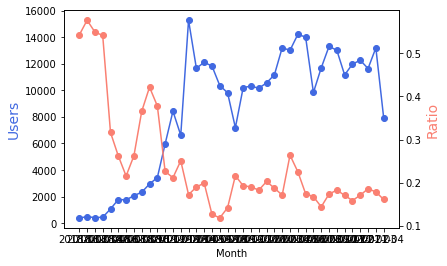

In [6]:
# 4. Plot two lines on a single graph
    #total distinct users who were sent at least 1 email by month and year.
    #the monthly percentage of users who were sent an email and were active the same day

date_format_1='%Y-%m'

# adding month column in df_emails
df_emails["EmailSentMonth"] = pd.to_datetime(df_emails.EmailSentDateTimeUtc, format='%Y-%m')
df_emails["EmailSentMonth"] = df_emails["EmailSentDateTimeUtc"].dt.strftime(date_format_1)

df_emails["DateOfActivityPST"] = pd.to_datetime(df_emails.EmailSentDateTimeUtc, format='%Y-%m')
df_emails["DateOfActivityPST"] = df_emails["DateOfActivityPST"].dt.strftime('%Y-%m-%d')

# adding month column in df_activity
df_activity["EmailSentMonth"] = pd.to_datetime(df_activity.DateOfActivityPST)
df_activity["EmailSentMonth"] = df_activity["EmailSentMonth"].dt.strftime('%Y-%m')

# calculating distinct users 
distinct_user = df_emails.groupby(by = ["EmailSentMonth"])["UserId"].nunique()

# caulculate number of users who were sent an email and were active the same day
email_active = pd.merge(df_emails, df_activity, how = "inner", on = ["DateOfActivityPST", "UserId"])

# group by email sent per month
email_active = email_active.groupby(by = ["EmailSentMonth_x"])["UserId"].count()

percentage = email_active/distinct_user

# plot the graph
import matplotlib.pyplot as plt
fig,ax=plt.subplots()

# blue line is the number of users
ax.plot(distinct_user.index, distinct_user.values,color="royalblue", marker="o")
ax.set_ylabel("Users",color="royalblue",fontsize=14)
plt.xlabel("Month")

# red line is the percentage 
ax2=ax.twinx()
ax2.plot(percentage.index, percentage.values,color="salmon", marker="o")
ax2.set_ylabel("Ratio",color="salmon",fontsize=14)



0.4998568581464231 0.5000908400224623


Text(0.5, 1.0, 'Ratio of email getting clicked')

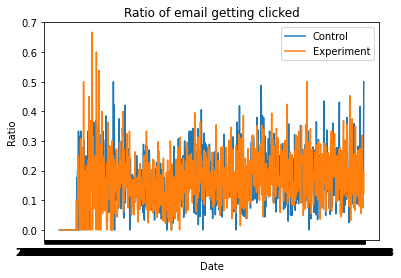

In [7]:
# 5. Once the experiment launches the team wants to track changes to the probability of an email getting clicked. 
#    In preparation for the experiment launch, plot a graph comparing the probability a user clicks on an email for each of the two experimental groups aggregated on a daily basis. 
#    In a paragraph, describe whether you think this is a good experimental design.

# subset the df_emails for control and experiment group
df_sample = df_emails[(df_emails['UserId'] > 20000000) & (df_emails['UserId'] < 1000000000000)]

df_experiment = df_sample[df_sample['UserId'] > 498689408027]
df_control = df_sample[df_sample['UserId'] < 498689408027]

# check if they are close to 50% of the sample
experiment_sample_percentage = len(df_experiment.index)/len(df_sample.index)
control_sample_percentage = len(df_control.index)/len(df_sample.index)

print(experiment_sample_percentage, control_sample_percentage)

# calculate the percentage for email clicks in both experiment and control group
experiment_open = df_experiment.groupby(by = ['DateOfActivityPST'])["EmailOpenedDateTimeUtc"].count()
experiment_click = df_experiment.groupby(by = ['DateOfActivityPST'])["EmailClickedDateTimeUtc"].count()
experiment_percentage = experiment_click/experiment_open

control_open = df_control.groupby(by = ['DateOfActivityPST'])["EmailOpenedDateTimeUtc"].count()
control_click = df_control.groupby(by = ['DateOfActivityPST'])["EmailClickedDateTimeUtc"].count()
control_percentage = control_click/control_open

# draw the plot
fig,ax = plt.subplots()

ax.plot(control_percentage.index, control_percentage.values)
ax.plot(experiment_percentage.index, experiment_percentage.values)
ax.legend(["Control", "Experiment"])
plt.xlabel("Date")
plt.ylabel("Ratio")
plt.title("Ratio of email getting clicked")

# I don't think it's a good experiment design. 
# It's reasonable to have 50% of the sample as control and experimental group, but it should be randomly assigned. 
# The UserId numbers are generated chronologically, so we are using the earlier users as control groupe and more recent users as experiment group. 
# Thus, it is certainly bisaed.
# Also, the original sampling excluded the earliest and the latest users. 
# If there is not a justifiable reason, they should be included.

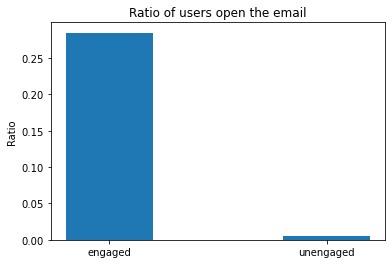

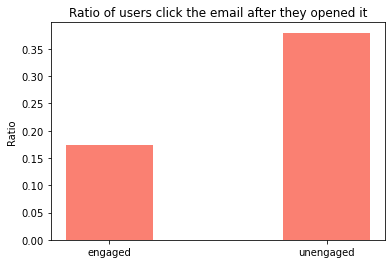

In [8]:
# 6.  The PM would like you to explore whether there is evidence that emails are effective with engaged users 
#     (users who log in without emails prompting them) but not effective on unengaged users.

# split engaged and unengaged users
unengaged_user = df_activity[df_activity["DateOfActivityPST"] < "2019-10-19"]


not_unengaged = df_activity[df_activity["DateOfActivityPST"] >= "2019-10-19"]
engaged_1 = pd.merge(left = not_unengaged, right = df_emails, on = ["UserId", "DateOfActivityPST"], how = "right")
engaged_2= pd.merge(left = not_unengaged, right = df_emails, on = ["UserId", "DateOfActivityPST"], how = "inner")
engaged_user = engaged_1[~engaged_1.isin(engaged_2)]

# calculate for unengaged users
unengaged_user = pd.merge(left = unengaged_user, right = df_emails, on = ["UserId", "DateOfActivityPST"], how = "left")
unengaged_open = unengaged_user["EmailOpenedDateTimeUtc"].count()/ len(unengaged_user.index)
unengaged_click = unengaged_user["EmailClickedDateTimeUtc"].count()/unengaged_user["EmailOpenedDateTimeUtc"].count()

# calculate for engaged users
engaged_user = pd.merge(left = engaged_user, right = df_emails, on = ["UserId", "DateOfActivityPST"], how = "left")
engaged_open = engaged_user["EmailOpenedDateTimeUtc_x"].count()/ len(engaged_user.index)
engaged_click = engaged_user["EmailClickedDateTimeUtc_x"].count()/engaged_user["EmailOpenedDateTimeUtc_x"].count()

# draw the plot 
label = ("engaged", "unengaged")

# plot for open rate
open_rate = (engaged_open, unengaged_open)

plt.bar(label, open_rate, width = 0.4)
plt.ylabel("Ratio")
plt.title("Ratio of users open the email")
plt.show()

#plot for click rate 
click_rate = (engaged_click, unengaged_click)

plt.bar(label, click_rate, width = 0.4, color = "salmon")
plt.ylabel("Ratio")
plt.title("Ratio of users click the email after they opened it")
plt.show()


In [9]:
from statsmodels.stats.proportion import proportions_ztest

unengaged_open_num = unengaged_user["EmailOpenedDateTimeUtc"].count()
engaged_open_num = engaged_user["EmailOpenedDateTimeUtc_x"].count()
unengaged_click_num = unengaged_user["EmailClickedDateTimeUtc"].count()
engaged_click_num = engaged_user["EmailClickedDateTimeUtc_x"].count()

unengaged_num = len(unengaged_user.index)
engaged_num = len(engaged_user.index)

# test for difference in open ratio
count = np.array([engaged_open_num, unengaged_open_num])
nobs = np.array([engaged_num, unengaged_num])
stat, pval = proportions_ztest(count, nobs)

print(stat, pval)

# H0: there is no difference between the ratio of engaged users and unengaged users opening the emails 
# H1: there is a difference between the ratio of engaged users and unengaged users opening the emails 

# p value < 0.05, there is a significant difference that engaged users are more likely to open the emails 
# P value means that there is a less than 5% chance that it happens because of random chances. The chance that we reject H0 when it is true is small. 

722.1797662918665 0.0


In [10]:
# test for difference in click ratio
count = np.array([engaged_click_num, unengaged_click_num])
nobs = np.array([engaged_open_num, unengaged_open_num])
stat, pval = proportions_ztest(count, nobs)

print(stat, pval)

# p value < 0.05, there is a significant difference that unengaged users are more likely to click on the emails after opening 

-53.96565587878446 0.0


array([[1.        , 0.47861009],
       [0.47861009, 1.        ]])

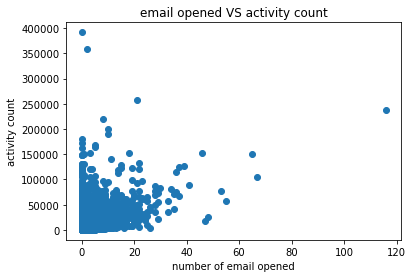

In [13]:
# Overall activity count and email open/click

# get the activity count of all users with email open/click
total = pd.merge(df_emails, df_activity, on = ["UserId", "DateOfActivityPST"], how = "outer")
total = total.dropna(subset = ["ActivityCount"])

# summarize data 
email_open = total.groupby(by = ["UserId"])["EmailOpenedDateTimeUtc"].count()
email_click = total.groupby(by = ["UserId"])["EmailClickedDateTimeUtc"].count()
activity_count = total.groupby(by = ["UserId"])["ActivityCount"].sum()

# visualization of the scatter plot between email_open and activity_count
# no obvious linear relationship 
plt.scatter(email_open.values, activity_count.values)
plt.xlabel("number of email opened")
plt.ylabel("activity count")
plt.title("email opened VS activity count")

# correlation coefficient 
np.corrcoef(email_open.values, activity_count.values)

# not strong enough correlation 

/var/folders/yp/dch1v8bn3gqgcyj9_k2vjj480000gn/T/ipykernel_8950/4223511040.py:3: RuntimeWarning: divide by zero encountered in log
  plt.scatter(np.log(email_open.values), activity_count.values)


Text(0.5, 1.0, 'email opened VS activity count')

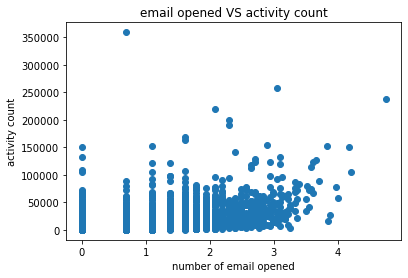

In [14]:
# log transformation 

plt.scatter(np.log(email_open.values), activity_count.values)
plt.xlabel("number of email opened")
plt.ylabel("activity count")
plt.title("email opened VS activity count")


array([[1.        , 0.33012057],
       [0.33012057, 1.        ]])

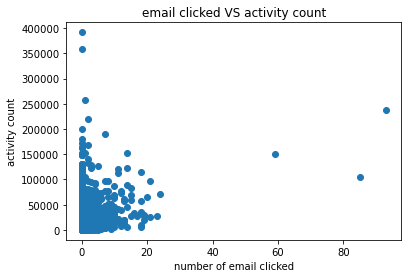

In [15]:
# visualization of the scatter plot between email_click and activity_count
# no obvious linear relationship
plt.scatter(email_click.values, activity_count.values)
plt.xlabel("number of email clicked")
plt.ylabel("activity count")
plt.title("email clicked VS activity count")

# correlation coefficient 
np.corrcoef(email_click.values, activity_count.values)

# not strong enough correlation 

/var/folders/yp/dch1v8bn3gqgcyj9_k2vjj480000gn/T/ipykernel_8950/3661493079.py:3: RuntimeWarning: divide by zero encountered in log
  plt.scatter(np.log(email_click.values), activity_count.values)


Text(0.5, 1.0, 'email opened VS activity count')

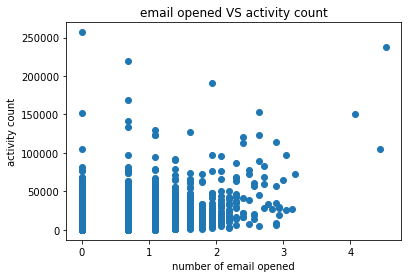

In [16]:
# log transformation 

plt.scatter(np.log(email_click.values), activity_count.values)
plt.xlabel("number of email opened")
plt.ylabel("activity count")
plt.title("email opened VS activity count")


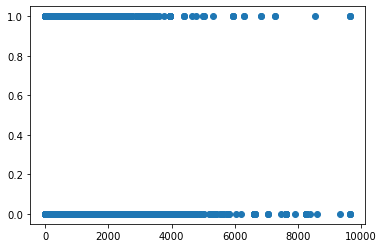

In [28]:
# current activity count and email open/click

# replace opening email with 1, not opening with 0
total['EmailOpenedDateTimeUtc'] = total['EmailOpenedDateTimeUtc'].fillna(0)
def not_0 (c): 
    if c == 0: 
        return 0 
    else: 
        return 1
total['EmailOpenedDateTimeUtc'] = total['EmailOpenedDateTimeUtc'].apply(not_0)

# visualize the result
x = total["ActivityCount"]
y = total['EmailOpenedDateTimeUtc']
plt.scatter(x,y)


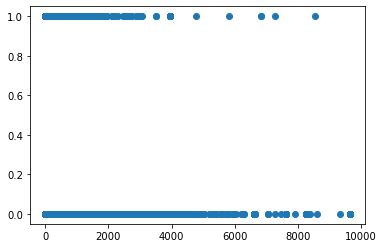

In [30]:
# replace clicking email with 1, not opening with 0
total['EmailClickedDateTimeUtc'] = total['EmailClickedDateTimeUtc'].fillna(0)
def not_0 (c): 
    if c == 0: 
        return 0 
    else: 
        return 1
total['EmailClickedDateTimeUtc'] = total['EmailClickedDateTimeUtc'].apply(not_0)

# visualize the result
x = total["ActivityCount"]
y = total['EmailClickedDateTimeUtc']
plt.scatter(x,y)

# There is no visiable pattern, so no need for logstic regression 

In [20]:
# Conclusion 

# User login
# Divide users as engaged(users who log in without emails prompting them) and unengaged(users who have not logged into FieldLevel for 6 months)
# Engaged users are substantially  more likely to open the emails
# However, after opening the emails, unengaged users are more likely to click on it 
# One possible explaination is that engaged users pay more attention to champaign emails as a continuation of their effort of engaging 
# They might have already been exposed to the email content while using the app, so they are less likely to click 
# Meawhile, for unengaged users, by breaking their usual behavior pattern and opening of email initially, 
# it showed their interest in the content so they have more incentives to click on the link

# Activity Count 
# There is no obvious relationship between the activity count of users and their decision on opening or clicking on the email 
# Neither the accumulated overall activity count or the current activity count status has any relationship with the email actions 